In [1]:
import sys
import calendar
import numpy as np
import pandas as pd
import math
symbols = ["Apple2018-23","Ginger2018-23","Arecanut2018-23","Beans2018-23","Drumstick2018-23","Coconut2018-23"]

quotes = []


def date_trans(date_str):
    if isinstance(date_str, str) and date_str.lower() != "nan":
        i = date_str.split('-')
        return '-'.join([i[2],d[i[1]],i[0]])

d = dict(enumerate(calendar.month_abbr))
d = {d[i]:str(i).zfill(2) for i in d if i>0}

for symbol in symbols:
    print("Fetching quote history for %r" % symbol, file=sys.stderr)
    url = (
        "{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))
    quotes[-1].drop(['state_name','district_name','market_center_name', 'Variety',
       'group_name'],axis=1, inplace=True)
    quotes[-1]['date_arrival'] = quotes[-1]['date_arrival'].apply(date_trans)
    quotes[-1].sort_values(by = "date_arrival")
    quotes[-1] = quotes[-1].groupby('date_arrival').mean().reset_index()
    
minimum_of_all = min(len(quotes[i]) for i in range(len(quotes)))
print(minimum_of_all)
for i, q in enumerate(quotes):
    diff = len(q) - minimum_of_all

    while diff:
        q = q.drop([i for i in range((len(q)//diff)-1,len(q), math.ceil(len(q)/diff))])
        q=q.reset_index(drop=True)
        diff = len(q)-minimum_of_all
    quotes[i]=q
    
# The daily variations of the quotes are what carry the most information
variation = np.vstack([q["MODAL"] for q in quotes])

Fetching quote history for 'Apple2018-23'
Fetching quote history for 'Ginger2018-23'
Fetching quote history for 'Arecanut2018-23'


1366


Fetching quote history for 'Beans2018-23'
Fetching quote history for 'Drumstick2018-23'
Fetching quote history for 'Coconut2018-23'


In [2]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

In [3]:
quotes[3]

,date_arrival,Arrival,MIN,MAX,MODAL
0,18-10-24,8.500000,2050.000000,2975.000000,2512.500000
1,18-10-25,17.142857,1954.571429,2747.285714,2328.714286
2,18-10-26,10.888889,2238.333333,2805.000000,2510.555556
3,18-10-28,12.500000,1950.000000,2700.000000,2300.000000
4,18-10-29,9.125000,2181.250000,2843.750000,2468.750000
...,...,...,...,...,...
1361,23-10-16,4.615385,3577.000000,4938.538462,4315.461538
1362,23-10-17,4.928571,3670.428571,4813.285714,4269.214286
1363,23-10-19,2.736842,3105.000000,4337.894737,3701.578947
1364,23-10-20,3.944444,3661.277778,4389.055556,4022.611111


In [4]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

names= np.array(symbols)
print(labels)
for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

[0 0 2 0 1 2]
Cluster 1: Apple2018-23, Ginger2018-23, Beans2018-23
Cluster 2: Drumstick2018-23
Cluster 3: Arecanut2018-23, Coconut2018-23


In [5]:
from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=2
)

embedding = node_position_model.fit_transform(X.T).T

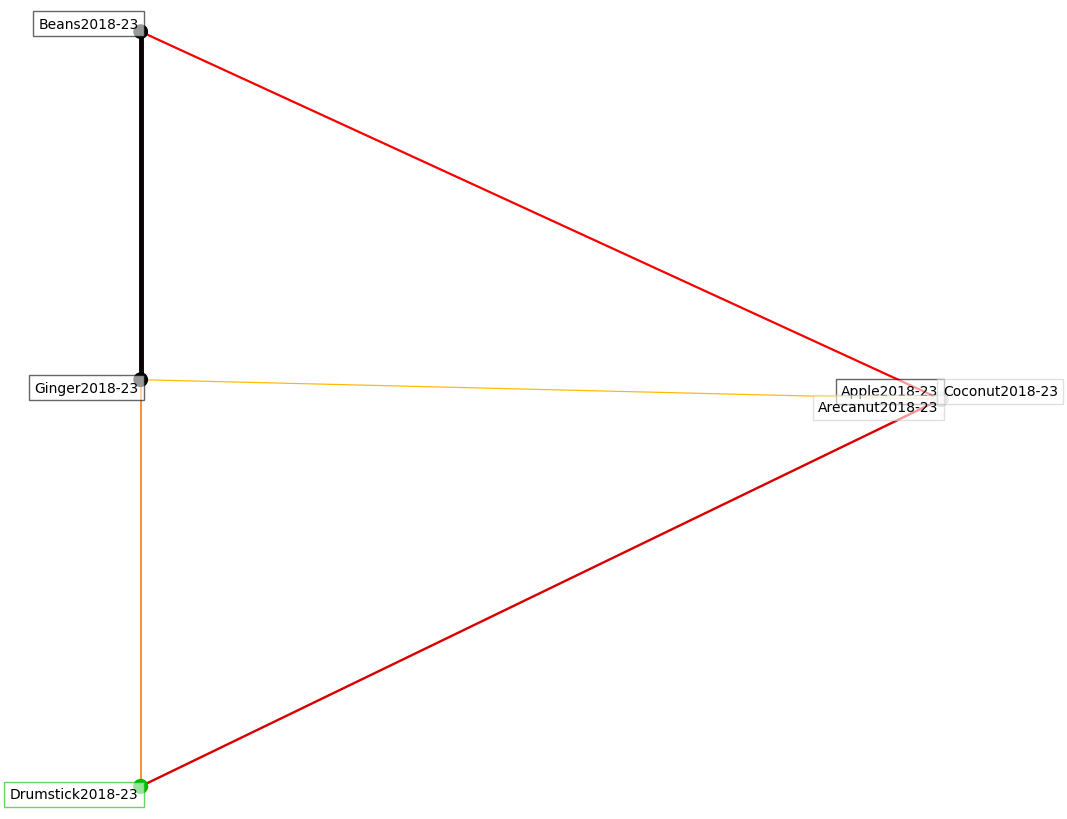

In [6]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()